In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [3]:
#MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
df = pd.read_csv('datameetupr (2).csv', index_col=[0], parse_dates=['date'])

In [5]:
df.head()

,Daily Active Users
date,
2013-01-01,1567
2013-01-02,3267
2013-01-03,4058
2013-01-04,4003
2013-01-05,3902


In [6]:
df.describe()

,Daily Active Users
count,894.000000
mean,8699.209172
std,3472.651537
min,257.000000
25%,5563.500000
50%,8957.000000
75%,11867.250000
max,15427.000000


In [7]:
split_date = '29-Jan-2015'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

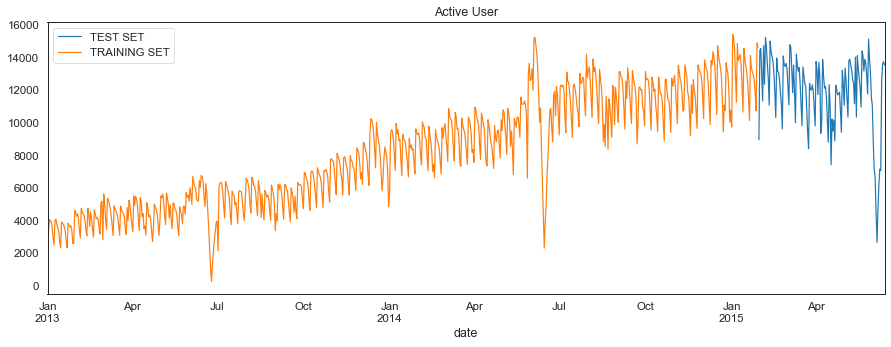

In [8]:
_ = test \
    .rename(columns={'Daily Active Users': 'TEST SET'}) \
    .join(train.rename(columns={'Daily Active Users': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Active User')

In [153]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [154]:
X_train, y_train = create_features(train, label='Daily Active Users')
X_test, y_test = create_features(test, label='Daily Active Users')

In [155]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[13:50:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [156]:
test['Prediction'] = reg.predict(X_test)
data_all = pd.concat([test, train], sort=False)

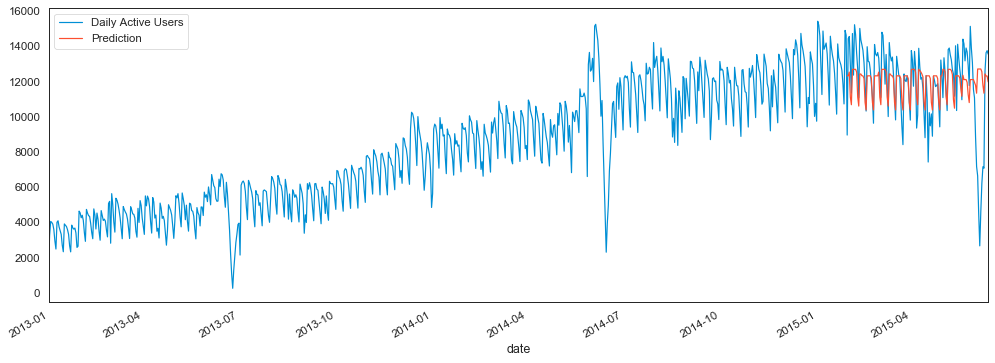

In [158]:
_ = data_all[['Daily Active Users','Prediction']].plot(figsize=(15, 6))

In [159]:
mean_absolute_percentage_error(y_true=test['Daily Active Users'],
                   y_pred=test['Prediction'])

16.606057697840964